In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import seaborn as sns

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline
from trajectory_post_funcs import calculate_heatmaps_from_trajectories
import customcmaps as ccmaps

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
server='expanse'
if server == 'comet':
    path_to_data = '/data/projects/Comet/cwp140/'
elif server == 'expanse':
    path_to_data = '/expanse/nfs/cw3e/cwp140/'
elif server == 'skyriver':
    path_to_data = '/home/dnash/comet_data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## use AR Scale as criteria for identifying AR at coast
varname = 'ar_scale'
thres = 0

## use Rutz AR dt for identifying AR at coast
varname = 'ar'
thres = 0

## use tARgetv4 AR dt for identifying AR at coast
varname = 'tARget'
thres = 0


In [4]:
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
water_year = (PRISM.date.dt.month >= 10) + PRISM.date.dt.year
PRISM.coords['water_year'] = water_year

def calculate_WY_contribution(PRISM, HUC8_ID):
    PRISM = PRISM.sel(HUC8=HUC8_ID)
    
    fname = path_to_data + '/preprocessed/ERA5_trajectories/combined_extreme_AR/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    ds = xr.open_dataset(fname)
    ds['ar_scale'] = ds.ar_scale.fillna(0) 
    
    ## calculate the total top-decile precipitation in each WY
    extreme_days = PRISM.where(PRISM.extreme > 0, drop=True).date.values
    ext_prec = PRISM.sel(date = extreme_days)
    extreme_prec = ext_prec.prec.groupby(ext_prec.water_year).sum(dim="date")

    extreme_prec = extreme_prec.to_dataframe()
    extreme_prec = extreme_prec.rename(columns={"prec": "Total Precipitation"})
    
    ## calculate the AR-related top-decile prec
    extreme_AR = ds.sel(start_date = extreme_days)
    extreme_AR = extreme_AR.where(extreme_AR[varname] > thres, drop=True).start_date.values
    
    ## select those dates from the PRISM dataset
    tmp = PRISM.sel(date=extreme_AR)
    ## convert to pandas df
    tmp = tmp.prec.to_dataframe()
    
    extreme_ar_prec = tmp.groupby(["water_year"], dropna=False).sum("date")
    extreme_ar_prec = extreme_ar_prec.rename(columns={"prec": "AR Associated"})
    
    ## calculate the total contribution fraction
    # extreme_contr = (extreme_ar_prec / extreme_prec)*100
    
    ## put into a dataframe
    df = pd.concat([extreme_prec, extreme_ar_prec], axis=1)
    # df = pd.DataFrame({'Total Precipitation': extreme_prec.values,
    #                    'AR Associated': extreme_ar_prec.prec.values},
    #                   index=extreme_prec.water_year.values)

    df['Percent'] = (df['AR Associated']/df['Total Precipitation'])*100
    
    return df

In [5]:
HUC8_ID_lst = ['14050001', '13010001', '10190002', '11020001']
HUC8_lbl_lst = ['Upper Yampa', 'Rio Grande Headwaters', 'Upper South Platte', 'Arkansas Headwaters']
df_lst = []
for i, HUC8ID in enumerate(HUC8_ID_lst):
    df = calculate_WY_contribution(PRISM, HUC8ID)
    df_lst.append(df)

In [6]:
df_lst

[                HUC8  Total Precipitation  AR Associated    Percent
 water_year                                                         
 2000        14050001             115.0416        25.6165  22.267162
 2001        14050001              14.8241            NaN        NaN
 2002        14050001              41.4046        15.3520  37.078006
 2003        14050001             147.7489        25.2244  17.072479
 2004        14050001              86.0690        44.5885  51.805528
 2005        14050001             141.7057        47.7811  33.718545
 2006        14050001             136.3190        33.7806  24.780552
 2007        14050001             114.3892        22.2214  19.426135
 2008        14050001              85.0095        46.1472  54.284756
 2009        14050001             110.4415        26.6502  24.130603
 2010        14050001             126.3897        33.1255  26.209019
 2011        14050001             311.6191        64.3215  20.641065
 2012        14050001             

/scratch/dnash/job_35414350/ipykernel_529131/1031734403.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  d1.set_xticklabels(d1.get_xticklabels(), rotation=45)


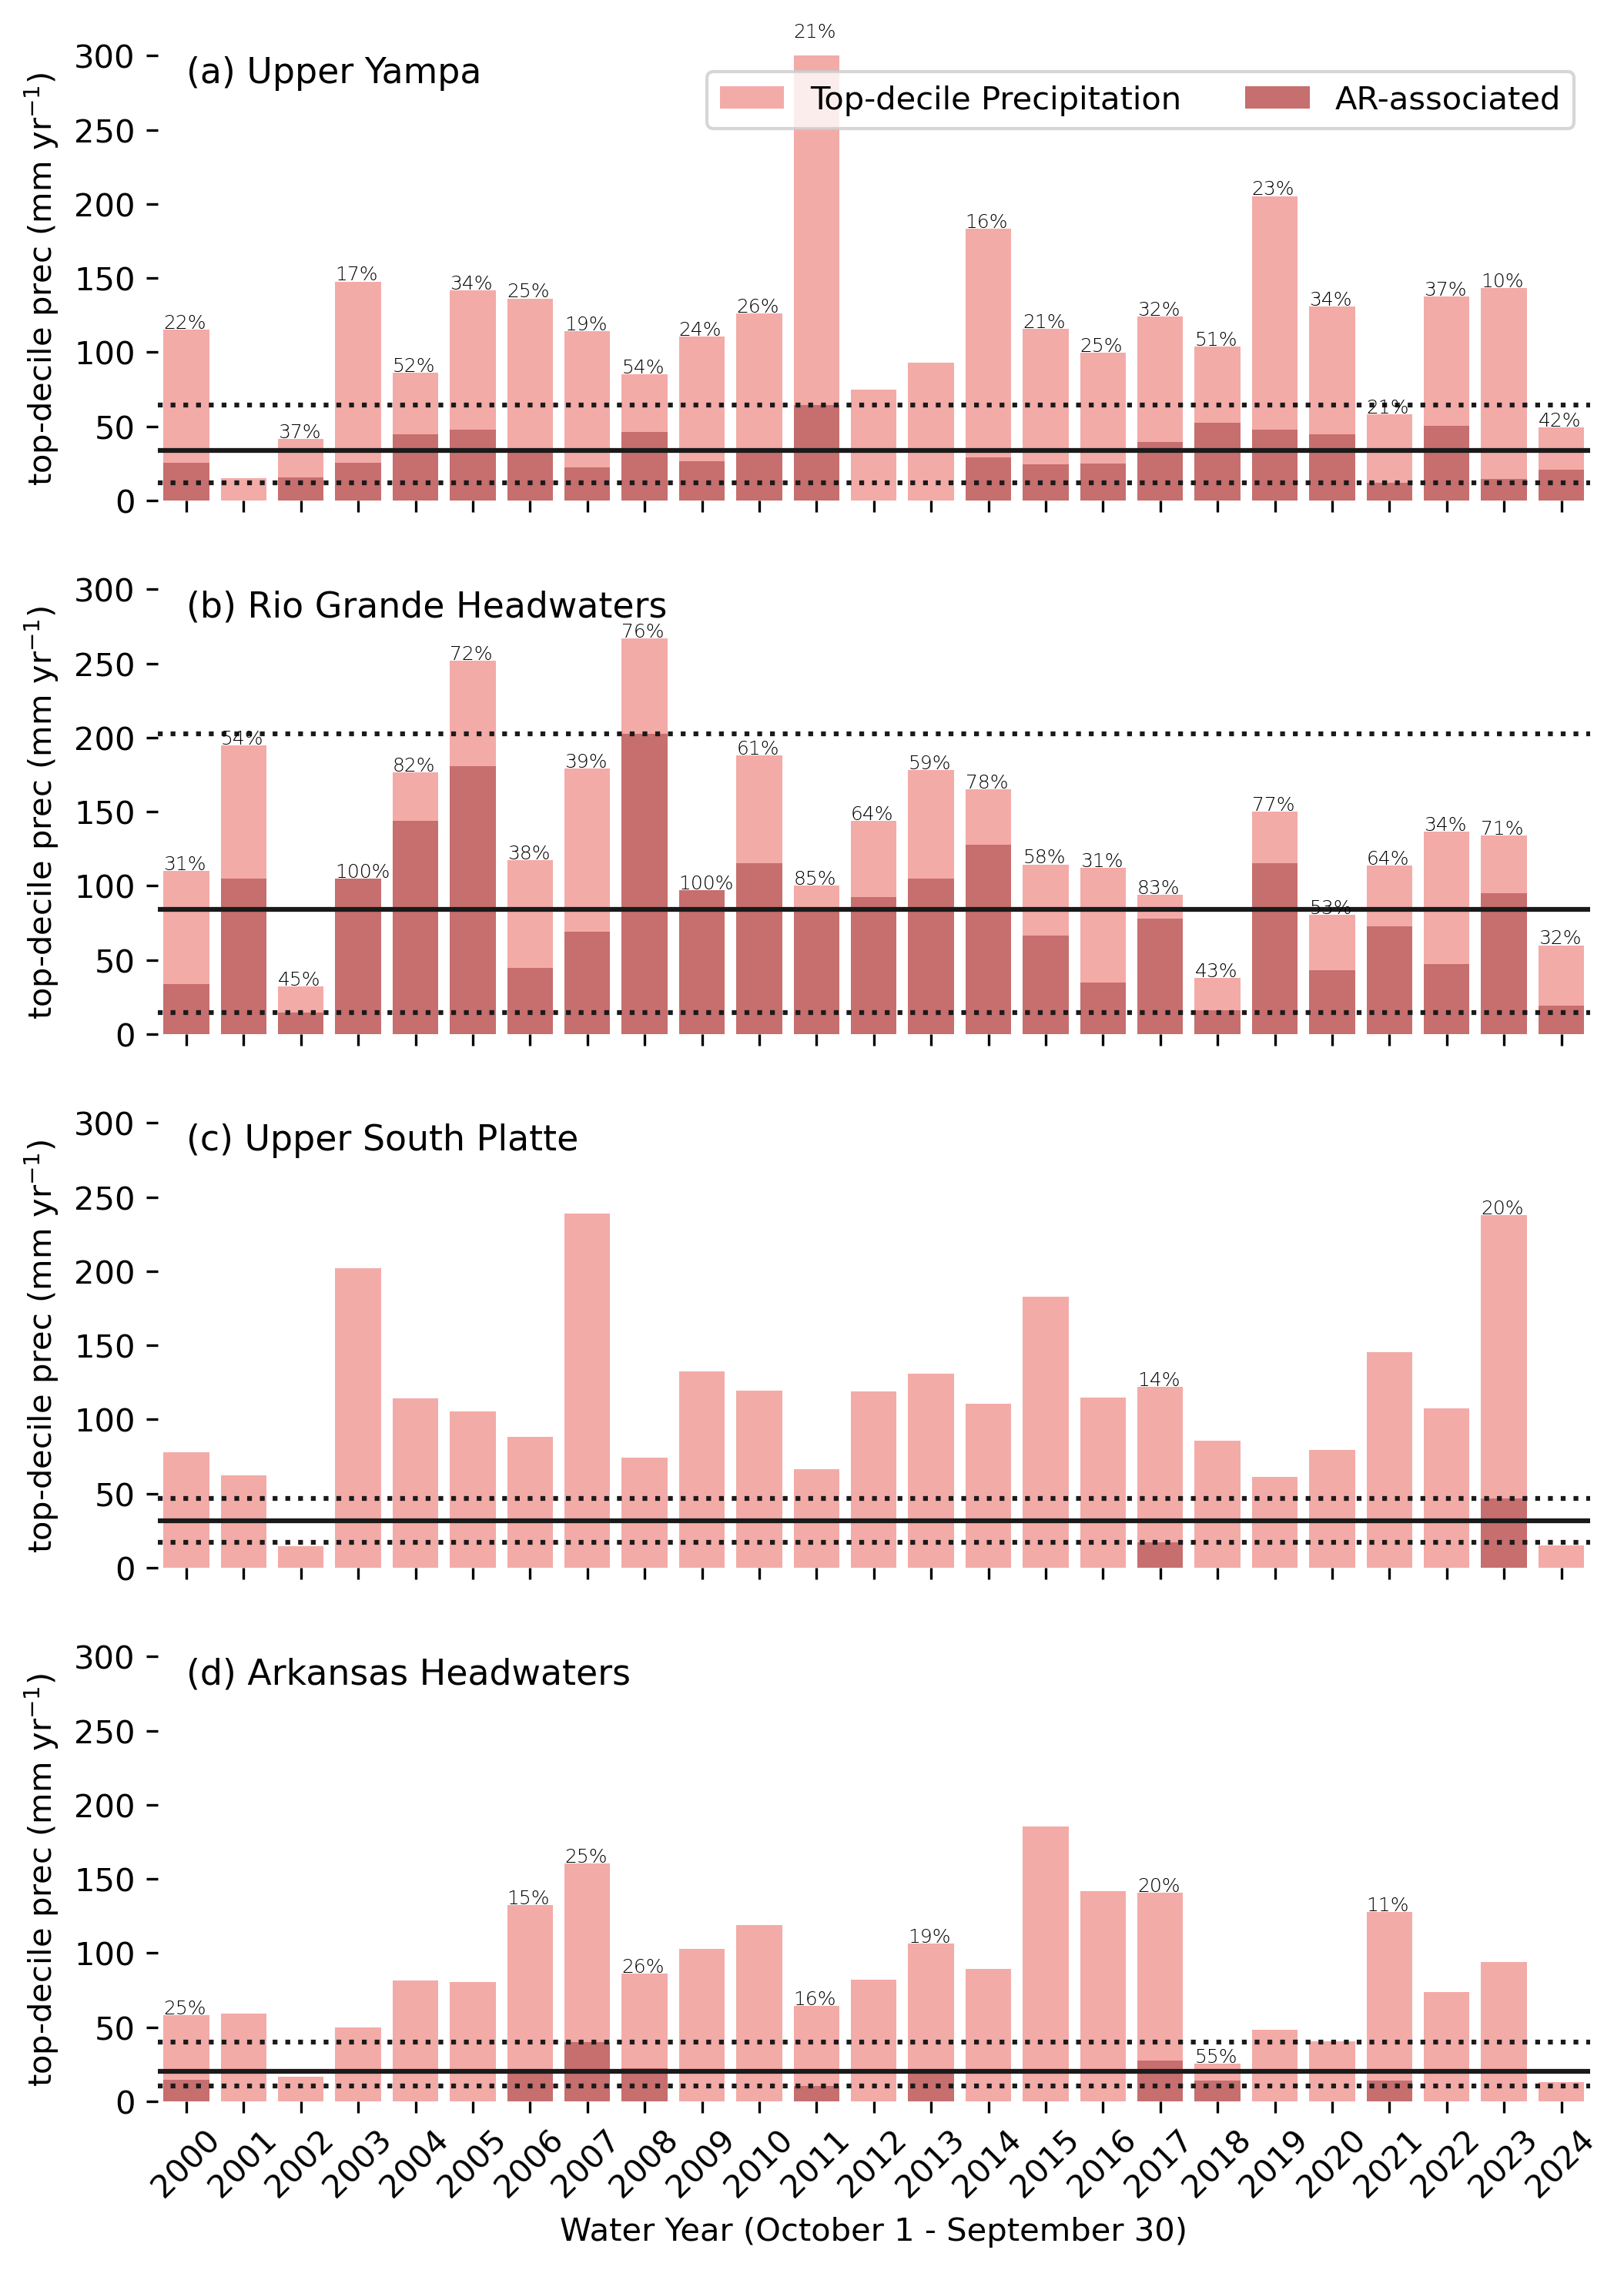

In [7]:
# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))
fig = plt.figure(figsize=(8,11.5))
fig.dpi = 300
fname = '../figs/time_series_extreme'
fmt1 = 'png'

nrows = 4
ncols = 1
gs = fig.add_gridspec(nrows, ncols)
color_list = ['b', 'r', 'g']

for k, df in enumerate(df_lst):
    ## Initialize the matplotlib figure
    ax = fig.add_subplot(gs[k, 0])
    
    # Plot the total precip
    sns.set_color_codes("pastel")
    d1 = sns.barplot(x=df.index, y="Total Precipitation", data=df, color='r', label="Top-decile Precipitation")
    
    # Plot the precipitation where ARs were involved
    sns.set_color_codes("muted")
    d2 = sns.barplot(x=df.index, y="AR Associated", data=df, color='r', label="AR-associated")
    
    # Add a legend and informative axis label
    ax.set(ylim=(0, 300), ylabel="top-decile prec (mm yr$^{-1}$)", xlabel="")
    sns.despine(left=True, bottom=True)
    #     ax.set_title(subtitles[i])

    ## add min/max/mean/median lines
    ax.axhline(y=df['AR Associated'].min(), color='k', linestyle=':')
    ax.axhline(y=df['AR Associated'].max(), color='k', linestyle=':') 
    ax.axhline(y=df['AR Associated'].mean(), color='k', linestyle='-')

    yloc = df['Total Precipitation'].values
    xloc = np.arange(0, len(df), 1)
    proportion = df['Percent'].values
    for i, (x, prop) in enumerate(zip(xloc, proportion)):
        if prop > 0:
            plt.text(x=x-0.4,
                     y=yloc[i]+1,
                     s=f'{int(np.round(prop, 0))}%',
                     color="black",
                     fontsize=6,
                     fontweight="light", zorder=200)
    
    if k == 0:
        ax.legend(ncol=2, loc="upper right", frameon=True)
    else:
        ax.get_legend().remove()
    
    if k == 3:
        d1.set_xticklabels(d1.get_xticklabels(), rotation=45)
        ax.set(xlabel="Water Year (October 1 - September 30)")
    else:
        ax.tick_params(labelbottom=False)

    titlestring = '({0}) {1}'.format(letter_lst[k], HUC8_lbl_lst[k])
    ax.text(0.02, 1., titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

    
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
plt.show()

In [8]:
# AR = ds.where(ds[varname] > thres, drop=True).ar_scale
# da_groupby_monthly = AR.groupby('start_date.month').count(['start_date'])
# ## calculate monthly count (interannual time series)
# monthly_count = AR.resample(start_date='1MS').count(['start_date'])

In [9]:
# monthly_count

In [10]:
# df = pd.DataFrame({'AR Count': monthly_count.values},
#                   index=monthly_count.start_date.values)

# df

In [11]:
# ## create datetime labels for the x-axis
# date_lst = df.index.values
# xtck_lbl = []
# for i, x in enumerate(date_lst):
#     t = pd.to_datetime(str(x))
#     xtck_lbl.append(t.strftime('%Y-%m'))

# xtcks = np.arange(0, len(date_lst), 1)

In [12]:
# fig = plt.figure(figsize=(10,3))
# fig.dpi = 300
# fname = '../figs/monthly_count_time_series_Upper_Yampa'
# fmt1 = 'png'
# gs = fig.add_gridspec(nrows=1, ncols=1)
# color_list = ['b', 'r', 'g']


# ## Initialize the matplotlib figure
# ax = fig.add_subplot(gs[0, 0])

# # Plot the precipitation where ARs were involved
# sns.set_color_codes("muted")
# d2 = sns.barplot(x=df.index, y="AR Count", data=df, color='b')

# # Add a legend and informative axis label
# ax.set(ylim=(0, 9), ylabel="ar frequency (#)", xlabel="")
# sns.despine(left=True, bottom=True)
# ax.set_xticks(xtcks[::12]) # set the labels every year
# ax.set_xticklabels(xtck_lbl[::12], fontsize=10)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
# fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
# plt.show()